In [1]:
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.svm import SVR
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
df = pd.read_csv('/content/drive/MyDrive/CarPrice_Assignment.csv')
df

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


#Processing

In [3]:
df['brand']=df['CarName'].apply(lambda x: x.lower().split()[0])

brands = {'maxda': 'mazda',
         'porcshce': 'porsche',
          'vokswagen': 'volkswagen',
          'vw': 'volkswagen',
          'toyouta': 'toyota'}
df['brand']=df['brand'].replace(brands)

In [4]:
units = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", 'eleven', 'twelve']
units = {x:y for x,y in zip(units, range(0,13))}

# df['doornumber']=df['doornumber'].replace(units)
df['cylindernumber']=df['cylindernumber'].replace(units).astype('int')

In [5]:
df.columns

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price', 'brand'],
      dtype='object')

In [6]:
int_feature=[ 'wheelbase', 'carlength', 'carwidth', 
             'carheight', 'curbweight',  'enginesize', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'cylindernumber']

cat_feature=['fueltype', 'aspiration', 'carbody', 'drivewheel', 'enginelocation', 
             'enginetype', 'fuelsystem', 'brand','symboling', 'doornumber',]

#DEA

In [7]:
ncol=4
nrow=6
subplot_index=[(row,col) for row in range(nrow) for col in range(ncol)]
fig = make_subplots(rows=nrow, cols=ncol,
                    subplot_titles=int_feature+cat_feature)

for feature, ind in zip(int_feature+cat_feature, subplot_index):
  row, col = ind
  fig.add_trace(go.Histogram(x=df[feature]),
                col=col+1, row=row+1)

fig.update_layout(
    showlegend=False,
    autosize=False,
    width=1000,
    height=1000)

fig.show()

In [8]:
#Drop enginelocation columns
df.drop(columns='enginelocation', inplace=True)
cat_feature.remove('enginelocation')

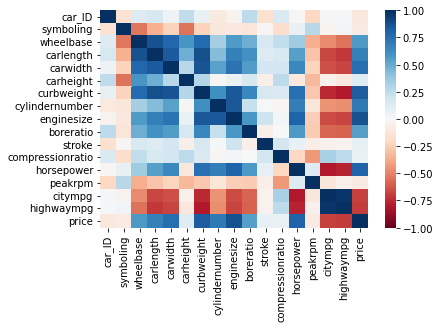

In [9]:
corr_map=df.corr()
sns.heatmap(corr_map, vmax=1, vmin=-1, cmap='RdBu')

In [10]:
ncol=4
nrow=4
subplot_index=[(row,col) for row in range(nrow) for col in range(ncol)]
fig = make_subplots(rows=4, cols=4,
                    subplot_titles=int_feature)

for feature, ind in zip(int_feature, subplot_index):
  row, col = ind
  fig.add_trace(go.Scatter(x=df[feature],
                           y=df['price'],
                           mode='markers'),
                col=col+1, row=row+1)

fig.update_layout(
    showlegend=False,
    autosize=False,
    width=1000,
    height=1000)

fig.show()

In [11]:
ncol=3
nrow=3
subplot_index=[(row,col) for row in range(nrow) for col in range(ncol)]
fig = make_subplots(rows=nrow, cols=ncol,
                    subplot_titles=cat_feature)

for feature, ind in zip(cat_feature, subplot_index):
  row, col = ind
  fig.add_trace(go.Box(x=df[feature],
                       y=df['price']),
                col=col+1, row=row+1)

fig.update_layout(
    showlegend=False,
    autosize=False,
    width=1000,
    height=1000)

fig.show()

# Feature Selection

In [12]:
corr_map[corr_map > 0.8]

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
car_ID,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
symboling,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wheelbase,NaN,NaN,1.000000,0.874587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
carlength,NaN,NaN,0.874587,1.000000,0.841118,NaN,0.877728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
carwidth,NaN,NaN,NaN,0.841118,1.000000,NaN,0.867032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
carheight,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
curbweight,NaN,NaN,NaN,0.877728,0.867032,NaN,1.000000,NaN,0.850594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.835305
cylindernumber,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.846031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
enginesize,NaN,NaN,NaN,NaN,NaN,NaN,0.850594,0.846031,1.000000,NaN,NaN,NaN,0.809769,NaN,NaN,NaN,0.874145
boreratio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
dummies=pd.get_dummies(df[cat_feature])

selected_dummies =['aspiration_std',
                    'drivewheel_rwd',
                    'brand_buick', 
                   'brand_jaguar', 
                   'brand_bmw', 
                   'brand_porsche',
                   'brand_audi', 
                   'brand_alfa-romero', 
                   'brand_peugeot', 
                   'brand_saab', 
                   'brand_volvo',
                   'carbody_convertible', 
                   'carbody_hardtop',
                   'fuelsystem_1bbl', 
                   'fuelsystem_2bbl']

final_df = pd.concat([df[int_feature+['price']], dummies], axis=1)

In [14]:
selected_int = ['carlength',  'carwidth',  'carheight',  'enginesize',  'boreratio',
 'stroke',  'compressionratio',  'horsepower',  'peakrpm',  'citympg',  'cylindernumber',  'price']
selected_feature=selected_int+list(dummies.columns)

# Model

In [42]:
result=[]



## Linear Regression

In [43]:
#Linear Regression
md=LinearRegression()
cv=KFold(n_splits=4, shuffle=True, random_state=42)
X=final_df.drop(columns='price')
y=final_df['price']

r2 = cross_val_score(md, X,  y, scoring='r2', cv=cv)
rmse = cross_val_score(md, X,  y, scoring='neg_root_mean_squared_error', cv=cv)
result.append({'model':'Linear Regression','r2': r2, 'rmse': rmse})

## Linear Regression with selected features

In [44]:
#Linear Regression with selected features
md=LinearRegression()
cv=KFold(n_splits=4, shuffle=True, random_state=42)
X=final_df[selected_feature].drop(columns='price')
y=final_df['price']

r2 = cross_val_score(md, X,  y, scoring='r2', cv=cv)
rmse = cross_val_score(md, X,  y, scoring='neg_root_mean_squared_error', cv=cv)
result.append({'model':'Linear Regression with selected features','r2': r2, 'rmse': rmse})

##Ridge Regression

In [45]:
#Ridge Regression
md=Ridge()
cv=KFold(n_splits=4, shuffle=True, random_state=42)
X=final_df.drop(columns='price')
y=final_df['price']

r2 = cross_val_score(md, X,  y, scoring='r2', cv=cv)
rmse = cross_val_score(md, X,  y, scoring='neg_root_mean_squared_error', cv=cv)
result.append({'model':'Ridge Regression','r2': r2, 'rmse': rmse})

##Ridge Regression with selected features

In [46]:
#Ridge Regression
md=Ridge()
cv=KFold(n_splits=4, shuffle=True, random_state=42)
X=final_df[selected_feature].drop(columns='price')
y=final_df['price']

r2 = cross_val_score(md, X,  y, scoring='r2', cv=cv)
rmse = cross_val_score(md, X,  y, scoring='neg_root_mean_squared_error', cv=cv)
result.append({'model':'Ridge Regression with selected features','r2': r2, 'rmse': rmse})

##Ridge Regression with polynomial features

In [47]:
squared_df = df[selected_int].drop(columns='price')**2
squared_df.columns = [x+'^2' for x in squared_df.columns]
scaled_data=pd.concat([final_df[selected_feature], squared_df], axis=1)

md=Ridge()
cv=KFold(n_splits=4, shuffle=True, random_state=42)
X=scaled_data.drop(columns='price')
y=final_df['price']

r2 = cross_val_score(md, X,  y, scoring='r2', cv=cv)
rmse = cross_val_score(md, X,  y, scoring='neg_root_mean_squared_error', cv=cv)
result.append({'model':'Ridge Regression with polynomial features','r2': r2, 'rmse': rmse})

## SVR

In [48]:
scaler= StandardScaler()
scaled_data=scaler.fit_transform(final_df.drop(columns='price'))

md = SVR(kernel='linear', C=10)
cv=KFold(n_splits=4, shuffle=True, random_state=42)
X=scaled_data
y=final_df['price']

r2 = cross_val_score(md, X,  y, scoring='r2', cv=cv)
rmse = cross_val_score(md, X,  y, scoring='neg_root_mean_squared_error', cv=cv)
result.append({'model':'SVR','r2': r2, 'rmse': rmse})

##SVR with selected features

In [49]:
scaler= StandardScaler()
scaled_data=scaler.fit_transform(final_df[selected_feature].drop(columns='price'))

md = SVR(kernel='linear', C=10)
cv=KFold(n_splits=4, shuffle=True, random_state=42)
X=scaled_data
y=final_df['price']

r2 = cross_val_score(md, X,  y, scoring='r2', cv=cv)
rmse = cross_val_score(md, X,  y, scoring='neg_root_mean_squared_error', cv=cv)
result.append({'model':'SVR with selected features','r2': r2, 'rmse': rmse})

##KNN

In [50]:
#KNN
scaler= StandardScaler()
md=KNeighborsRegressor()
cv=KFold(n_splits=4, shuffle=True, random_state=42)
X=scaler.fit_transform(final_df.drop(columns='price'))
y=final_df['price']

r2 = cross_val_score(md, X,  y, scoring='r2', cv=cv)
rmse = cross_val_score(md, X,  y, scoring='neg_root_mean_squared_error', cv=cv)
result.append({'model':'KNN','r2': r2, 'rmse': rmse})

# Conclusion

In [51]:
result_df = pd.DataFrame.from_records(result)
result_df[['r2_'+str(x+1) for x in range(4)]]=result_df['r2'].to_list()
result_df[['rmse_'+str(x+1) for x in range(4)]]=result_df['rmse'].to_list()
result_df

,model,r2,rmse,r2_1,r2_2,r2_3,r2_4,rmse_1,rmse_2,rmse_3,rmse_4
0,Linear Regression,"[0.8874567440669151, 0.859181306164531, 0.9158...","[-2759.460921187847, -2484.2384199308326, -208...",0.887457,0.859181,0.915820,0.908155,-2759.460921,-2484.238420,-2083.938600,-2815.177378
1,Linear Regression with selected features,"[0.8809519932814196, 0.8520727623676017, 0.872...","[-2838.086151130502, -2546.1687987765868, -256...",0.880952,0.852073,0.872670,0.896745,-2838.086151,-2546.168799,-2562.992476,-2984.924638
2,Ridge Regression,"[0.8986539086429743, 0.8575041011278668, 0.918...","[-2618.593058487964, -2498.988748981935, -2047...",0.898654,0.857504,0.918701,0.895599,-2618.593058,-2498.988749,-2047.977504,-3001.433563
3,Ridge Regression with selected features,"[0.8967084413936005, 0.8552971664526942, 0.904...","[-2643.607198331857, -2518.266197189505, -2215...",0.896708,0.855297,0.904818,0.911784,-2643.607198,-2518.266197,-2215.946239,-2759.000221
4,Ridge Regression with polynomial features,"[0.9098327518224882, 0.871908493141693, 0.8470...","[-2469.954301918377, -2369.317627552665, -2808...",0.909833,0.871908,0.847079,0.894852,-2469.954302,-2369.317628,-2808.762234,-3012.159372
5,SVR,"[0.688569393717783, 0.6277854998990315, 0.7537...","[-4590.343188887253, -4038.868952584583, -3564...",0.688569,0.627785,0.753734,0.690381,-4590.343189,-4038.868953,-3564.380385,-5168.814246
6,SVR with selected features,"[0.6580599992280698, 0.6435892294019596, 0.723...","[-4809.937847152603, -3952.1964898697092, -377...",0.658060,0.643589,0.723213,0.652838,-4809.937847,-3952.196490,-3778.807078,-5473.224945
7,KNN,"[0.758513693868415, 0.5640235505131685, 0.7077...","[-4042.1345395811345, -4371.139163946652, -388...",0.758514,0.564024,0.707719,0.734591,-4042.134540,-4371.139164,-3883.131063,-4785.584930


In [81]:
def linebreak(s):
  x= s.split()
  x.insert(2, '<br>')
  x.insert(5, '<br>')
  return ' '.join(x)

fig = make_subplots(rows=2)
x_axis = [linebreak(x) for x in result_df['model']]

for col in result_df.columns[3:]:
  if 'r2' in col:
    fig.add_trace(go.Bar(x=x_axis,
                        y=result_df[col],
                         name=col),
                  row=1, col=1)
  else:
    fig.add_trace(go.Bar(x=x_axis,
                        y=-result_df[col],
                         name=col),
                  row=2, col=1) 

fig.add_trace(go.Scatter(x=x_axis,
                         y=result_df['r2'].apply(lambda x: sum(x)/len(x)),
                         name='Average r2'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=x_axis,
                         y=result_df['rmse'].apply(lambda x: -sum(x)/len(x)),
                         name='Average RMSE'),
              row=2, col=1)

fig.update_layout(xaxis = go.layout.XAxis(
                          tickangle = 0),
                  xaxis2 = go.layout.XAxis(
                          tickangle = 0),
                  bargap=0.4)

fig.show()